In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/helpers"))

In [20]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"

import time

t0 = time.time()
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)
t1 = time.time()
total_time = t1-t0
print("Time elapsed:",total_time,"s")

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.
Time elapsed: 1.8901212215423584 s


In [3]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


In [39]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
#     t_x_data[i] = i*2#np.sin(i/100) #train_RO_se3s[i][0,3]
    t_y_data[i] = i #train_RO_se3s[i][1,3]    
    t_x_data[i] = train_RO_se3s[i][0,3]
#     t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [40]:
dim1_data = t_x_data
dim2_data = t_y_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
# dim1_data_scaled = dim1_data
# dim2_data_scaled = dim2_data

[[-1.37088955]
 [-1.36970395]
 [-1.3675547 ]
 ...
 [-1.37270585]
 [-1.38132449]
 [-1.37052975]]
(5400, 1)
[[-1.37088955 -1.73173009]
 [-1.36970395 -1.73108859]
 [-1.3675547  -1.73044709]
 ...
 [-1.37270585  1.73044709]
 [-1.38132449  1.73108859]
 [-1.37052975  1.73173009]]
(5400, 2)
dataX: torch.Size([5390, 10, 2])
trainX: torch.Size([2695, 10, 2])
valX: torch.Size([2695, 10, 2])
dataY: torch.Size([5390, 2])
trainY: torch.Size([2695, 2])
valY: torch.Size([2695, 2])


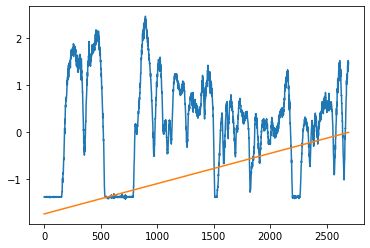

In [41]:
from data_preparation import sliding_window_delta

training_data = np.array(dim1_data_scaled.reshape(-1,1))
print(training_data)
print(training_data.shape)
training_data = np.append(training_data, dim2_data_scaled.reshape(-1,1),axis=1)
print(training_data)
print(training_data.shape)

seq_length = 10
x, y = sliding_window_delta(training_data, seq_length)

train_val_ratio = 0.5
train_size = int(len(y) * train_val_ratio)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

valX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
valY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("valX:",valX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("valY:",valY.shape)

plt.plot(trainX[:,0,0])
plt.plot(trainX[:,0,1])

In [42]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_dim, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [32]:
torch.manual_seed(0)

num_epochs = 151
learning_rate = 0.01

input_size = 2
output_size = 2
hidden_size = 30
num_layers = 1

lstm = LSTM(input_size, output_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

print(lstm(trainX).size())
print(trainY.size())

t0 = time.time()
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX).reshape(-1,output_size)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
t1 = time.time()
total_time = t1-t0
print("Time elapsed:",total_time,"s")

torch.Size([2695, 2])
torch.Size([2695, 2])
Epoch: 0, loss: 0.00575
Epoch: 50, loss: 0.00000
Epoch: 100, loss: 0.00000
Epoch: 150, loss: 0.00000
Time elapsed: 12.6334707736969 s


In [47]:
from torch.utils.data.dataset import TensorDataset
train_ds = TensorDataset(trainX,trainY)
valid_ds = TensorDataset(valX,valY)

from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 100
epochs = 10
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = lstm #BiggerNetwork() #SimpleNetwork()
loss_func = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 0.017118577620771357
1 0.02862073639355918
2 0.04336478430535886
3 0.09577733658060625
4 0.1658128868574225
5 0.30745916990545996
6 0.3549882802206864
7 0.4677330547034851
8 0.3104735450311141
9 0.2745090698363719


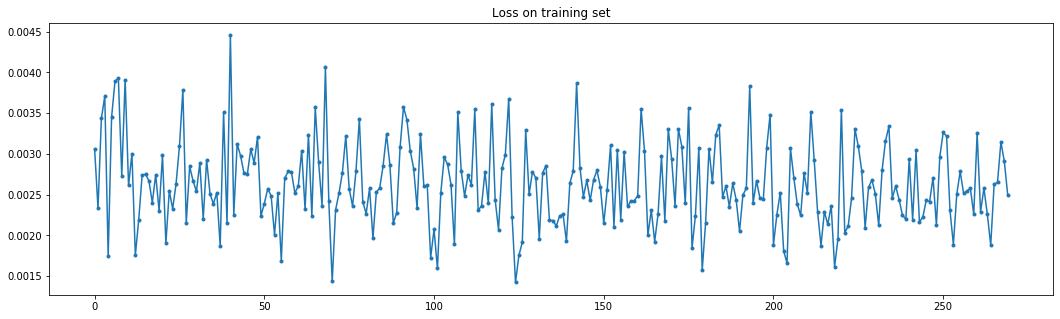

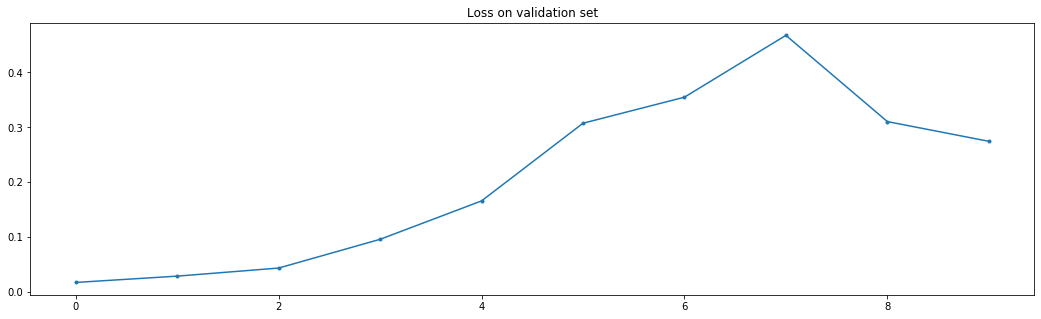

In [48]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

In [35]:
print(output_size)
print(lstm(trainX).shape)
print(outputs.size())
print(trainY.size())

2
torch.Size([2695, 2])
torch.Size([2695, 2])
torch.Size([2695, 2])


In [36]:
def appender(input_seq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
    import numpy as np

    input_seq = np.delete(input_seq,0,axis=0)
    updated_input_seq = np.append(input_seq,new_val).reshape(-1,2) # hacky, remove this 2
    return updated_input_seq
my_arr = np.array([[0,1],[2,3],[4,5],[6,7]])
print(my_arr,"shape:",my_arr.shape)
my_new_arr = appender(my_arr,[8,9])
print(my_new_arr,"shape:",my_new_arr.shape)

[[0 1]
 [2 3]
 [4 5]
 [6 7]] shape: (4, 2)
[[2 3]
 [4 5]
 [6 7]
 [8 9]] shape: (4, 2)


In [37]:
def get_predictions_out_to_horizon(model,horizon,input_seq,future_val):
    """
    Predict values out to a horizon
    """
    import numpy as np
    import torch
    from torch.autograd import Variable 

    cumulative_predictions = np.empty(0)
    cumulative_predictions = np.append(cumulative_predictions,future_val)
#     print("Future val:",future_val,'shape:',future_val.shape)
#     print("Input seq:",input_seq,'shape:',input_seq.shape)
    for i in range(horizon-1):
        updated_input_seq = appender(input_seq,future_val)
        updated_input_seq = updated_input_seq[np.newaxis,...]
        updated_input_seq = Variable(torch.tensor(updated_input_seq))
        next_prediction = model(updated_input_seq)

        # Update states
        input_seq = updated_input_seq
        future_val = next_prediction.data.numpy()+updated_input_seq[0][-1].data.numpy()
        cumulative_predictions = np.append(cumulative_predictions,future_val)
    return cumulative_predictions.reshape(-1,2)

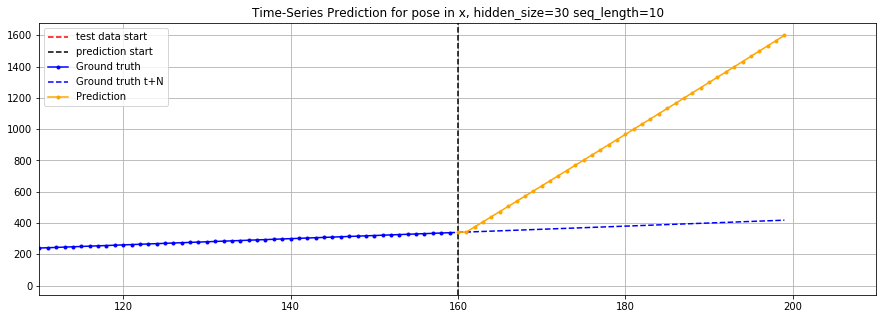

In [38]:
# from prediction import appender, get_predictions_out_to_horizon
prediction_start_index = 160 #int(len(dataY)*train_test_ratio) + 10 #160
horizon = 40
lstm.eval()
input_seq = dataX[prediction_start_index]
future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.reshape(1,-1)
predictions = get_predictions_out_to_horizon(lstm,horizon,input_seq,future_val)

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
gt_x_vals_rescaled = (dataX.data.numpy()[:,-1,0]+dataY.data.numpy()[:,0])*dim1_data.std()+dim1_data.mean()

dim1_predictions_rescaled = predictions[:,0]*dim1_data.std()+dim1_data.mean()
dim2_predictions_rescaled = predictions[:,1]*dim2_data.std()+dim2_data.mean()

x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_x_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_x_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,dim1_predictions_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

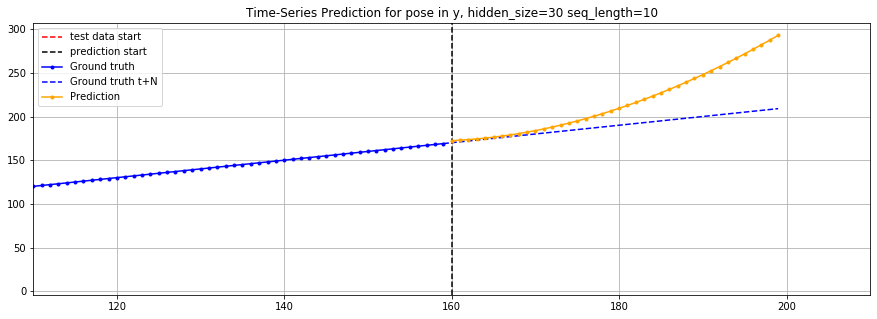

In [31]:
gt_y_vals_rescaled = (dataX.data.numpy()[:,-1,1]+dataY.data.numpy()[:,1])*dim2_data.std()+dim2_data.mean()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_y_vals_rescaled[:prediction_start_index],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_y_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,dim2_predictions_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in y, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [14]:
lstm(dataX[[20]])

tensor([[ 0.0032, -0.0562]], grad_fn=<AddmmBackward>)

In [15]:
lstm(dataX[[1000]])

tensor([[ 0.0035, -0.0471]], grad_fn=<AddmmBackward>)